## Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def read_data(file_path):
    return pd.read_csv(
        file_path, 
        sep=';',
        header=0,
        compression='gzip', 
        parse_dates=['timestamp', 'lastStart']
    )

### Data

In [4]:
%%time
train_ = read_data('../data/raw/training_data.csv.gz')
test_ = read_data('../data/raw/test_data.csv.gz')
print(train_.shape, test_.shape)

(3738763, 17) (3739968, 16)
CPU times: user 2min 9s, sys: 3.03 s, total: 2min 12s
Wall time: 2min 12s


In [5]:
# sample for easy testing
train = train_.sample(n=10000, random_state=100).reset_index(drop=True)
test = test_.sample(n=10000, random_state=100).reset_index(drop=True)

In [6]:
train.head(2)

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c3a4fa40c7e35f21632a67c,2019-01-12 20:35:48.851000+00:00,5c232d77f76b8fd4b9ab3c99,android,8.0.0,2626028,RU,49,44,5,1,2019-01-12 20:33:57.144000+00:00,21,33,cellular,HUAWEI RNE-L21,0
1,5c383b79d705e1884b4f0bd0,2019-01-11 06:45:13.455000+00:00,5c3788bb705b743d24f107e2,ios,12.1.2,1471374,JP,429,425,16,7,2019-01-11 06:44:33.502000+00:00,13,118,wifi,"iPhone8,2",0


### Dataset

In [7]:
CATEGORICAL_FEATURES = [
    'campaignId',
    'platform',
    'softwareVersion',
    'sourceGameId',
    'country',
    'connectionType',
    'deviceType',
]
NUMERICAL_FEATURES = [
    'startCount',
    'viewCount',
    'clickCount',
    'installCount',
    'startCount1d',
    'startCount7d',
    'fromLastStart', # new feature
]
TARGET = 'install'

def generate_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature generation
    """
    # add diff in hours between the event and last any campaign start
    data = df.copy()
    data['fromLastStart'] = (data['timestamp'] - data['lastStart']).apply(lambda x: x.total_seconds() / 3600)
    return data

def process_raw(df: pd.DataFrame,
                mode: str = 'train') -> pd.DataFrame:
    """
    Preprocess a raw data into a dataset
    """
    # feature generation
    df = generate_features(df)

    # handling NaNs
    df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].fillna(value='Unknown')
    df[NUMERICAL_FEATURES] = df[NUMERICAL_FEATURES].fillna(value=-1)
    
    # resulting columns
    columns = CATEGORICAL_FEATURES + NUMERICAL_FEATURES
    if mode == 'train':
        columns += [TARGET]
        
    return df[columns]

In [8]:
%%time
train_df = process_raw(train, 'train')
test_df = process_raw(test, 'test')

CPU times: user 60.7 ms, sys: 2.33 ms, total: 63 ms
Wall time: 61.9 ms


In [9]:
train_df.head(2)

,campaignId,platform,softwareVersion,sourceGameId,country,connectionType,deviceType,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,fromLastStart,install
0,5c232d77f76b8fd4b9ab3c99,android,8.0.0,2626028,RU,cellular,HUAWEI RNE-L21,49,44,5,1,21,33,0.031030,0
1,5c3788bb705b743d24f107e2,ios,12.1.2,1471374,JP,wifi,"iPhone8,2",429,425,16,7,13,118,0.011098,0


In [10]:
test_df.head(2)

,campaignId,platform,softwareVersion,sourceGameId,country,connectionType,deviceType,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,fromLastStart
0,5bb7211e53625e0830b9731a,ios,12.1.1,51050,GB,wifi,"iPad6,11",41,25,0,2,3,27,2.991623
1,5c2c5ef7d3e81e3aefbf830e,android,6.0,15939,RO,cellular,LGE LG-K430,3,2,0,0,3,3,0.539225


### Pipeline/model/metrics

In [11]:
from os import path
from datetime import datetime
from typing import Tuple
import yaml
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

RANDOM_SEED = 100


def build_pipeline() -> Pipeline:
    """
    Build a pipeline of a scaler, one-hot encoder and a classifier model
    """
    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('scaler', num_transformer, NUMERICAL_FEATURES),
                                                   ('ohe', cat_transformer, CATEGORICAL_FEATURES)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(random_state=RANDOM_SEED))])
    return pipeline

def cross_validation_scores(pipeline: Pipeline, 
                            X: pd.DataFrame,
                            y: pd.Series,
                            cv: int = 5) -> dict:
    """
    Get cross validation scores
    """
    params = {'estimator': pipeline, 
              'X': X, 
              'y': y}
    
    roc_auc = cross_val_score(**params, scoring='roc_auc')
    roc_auc_cv = f"{roc_auc.mean():.3f} (+-{roc_auc.std():.3f})"
    
    brier = -cross_val_score(**params, scoring='neg_brier_score')
    brier_cv = f"{brier.mean():.3f} (+-{brier.std():.3f})"
    
    log_loss = -cross_val_score(**params, scoring='neg_log_loss')
    log_loss_cv = f"{log_loss.mean():.3f} (+-{log_loss.std():.3f})"
    
    return {
        'roc_auc': roc_auc_cv,
        'brier': brier_cv,
        'log_loss': log_loss_cv,
    }

def save_model(pipeline: Pipeline, version: str) -> None:
    """
    Save model/pipeline into pickle file
    """
    model_path = path.join('../models/', f'pipeline_{version}.pkl')
    joblib.dump(pipeline, model_path)
    
def save_report(pipeline: Pipeline, metrics: dict, version: str) -> None:
    """
    Save model parameters and cross-validation metrics into YAML file
    """
    report_path = path.join('../reports/', f'report_{version}.yaml')
    report = {
        'model_params': {k: v for k, v in pipeline.get_params().items() if k.startswith('classifier_')},
        'metrics_cross_val': metrics,
    }
    with open(report_path, 'w') as f:
        yaml.dump(report, f, allow_unicode=True, default_flow_style=False)
        
def save_predictions(predictions: np.array, version: str) -> None:
    """
    Save model predictions for test data
    """
    preds_path = path.join('../data/predictions/', f'predictions_{version}.npy') 
    with open(preds_path, 'wb') as f:
        np.save(f, predictions)

def train_pipeline(train_df: pd.DataFrame) -> Tuple[Pipeline, dict]:
    """
    Train a model pipeline, report metrics, save it
    """
    X, y = train_df[CATEGORICAL_FEATURES+NUMERICAL_FEATURES], train_df[TARGET]
    print(f'The dataset {X.shape} is ready.')

    pipeline = build_pipeline()
    print('The pipeline is built:', pipeline)

    pipeline.fit(X, y)
    print('The model is trained.')
    
    metrics = cross_validation_scores(pipeline, X, y)
    print('The cross validation metrics are done.')
    
    version = datetime.now().strftime('%Y%m%d')
    save_model(pipeline, version)
    save_report(pipeline, metrics, version)
    print('The model and report with metrics are saved.')

    return pipeline, metrics

def make_predictions(pipeline: Pipeline, test_df: pd.DataFrame) -> None:
    """
    Make a prediction for a probability of class=1 and save it
    """
    preds = pipeline.predict_proba(test_df[CATEGORICAL_FEATURES+NUMERICAL_FEATURES])[:, 1]
    version = datetime.now().strftime('%Y%m%d')
    save_predictions(preds, version)
    return preds

In [12]:
pipeline, metrics = train_pipeline(train_df)

The dataset (10000, 14) is ready.
The pipeline is built: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['startCount', 'viewCount',
                                                   'clickCount', 'installCount',
                                                   'startCount1d',
                                                   'startCount7d',
                                                   'fromLastStart']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['campaignId', 'platform',
                                                   'softwareVersion',
                                                   'sourceGameId', 'country',
                                                   'connectionType',
                            

In [13]:
metrics

{'roc_auc': '0.549 (+-0.049)',
 'brier': '0.011 (+-0.000)',
 'log_loss': '0.062 (+-0.003)'}

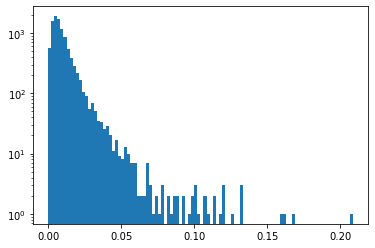

In [14]:
preds = make_predictions(pipeline, test_df)
plt.hist(preds, bins=100, log=True)
plt.show()